In [1]:
%load_ext sql

In [2]:
%sql sqlite:///C:/sqlite/chinook2.db

# 1) Introduction

A **subquery is a query nested** inside another query. For example, we can write this query to compute the average number of sales per billing city (billing_city) from the invoice table in the Chinook database.

```sql
SELECT AVG(billing_city_tally) AS billing_country_tally_avg
  FROM (SELECT billing_city, COUNT(*) AS billing_city_tally
          FROM invoice
         GROUP BY billing_city);
```

What if we could write the subquery separately and use it in the outer query? This would provide at least two benefits:

* It would improve the readability of the query.

* It would reuse a query without forcing a rewrite.

We can do this using the `WITH` clause, which is the subject of this lesson. 

Let's look at how we can rewrite the query above using a WITH clause

In [3]:
%%sql
WITH
city_sales_table AS (
SELECT billing_city, COUNT(*) AS billing_city_tally
  FROM invoice
 GROUP BY billing_city
)

SELECT AVG(billing_city_tally) AS billing_country_tally_avg
  FROM city_sales_table;

 * sqlite:///C:/sqlite/chinook2.db
Done.


billing_country_tally_avg
11.584905660377359


Notice that we name the subquery `city_sales_table` and then use this name as the table name in the `FROM` clause of the outer query. 

# 2) Using a Single Common Table Expression (CTE)

Let's explain this query. We can split this query into two parts:

* The first part allows us to name the subquery (like we do with aliases). We call this part **Common Table Expression (CTE)**.

* The second part is the outer query, where we can use the subquery name we declared in the previous part.

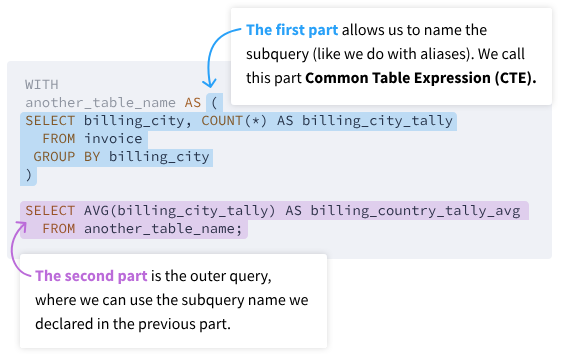

An important note is that **we wrap CTEs in parentheses** like subqueries.

## Instructions

1. Inspired by the previous query, edit the following query in the Code Editor to introduce the `WITH` clause.

Give the subquery the name customer_avg_table.

```sql
SELECT c.last_name, c.first_name, i.total_avg
  FROM customer AS c
  JOIN (SELECT customer_id, AVG(total) AS total_avg
          FROM invoice
         GROUP BY customer_id) AS i
    ON c.customer_id = i.customer_id;
```

In [4]:
%%sql
WITH 
customer_avg_table AS (SELECT customer_id, AVG(total) AS total_avg
          FROM invoice
         GROUP BY customer_id)

SELECT c.last_name, c.first_name, i.total_avg
  FROM customer AS c
  JOIN customer_avg_table AS i
    ON c.customer_id = i.customer_id
LIMIT 5;

 * sqlite:///C:/sqlite/chinook2.db
Done.


last_name,first_name,total_avg
Gonçalves,Luís,8.376923076923076
Köhler,Leonie,7.47
Tremblay,François,11.11
Hansen,Bjørn,8.03
Wichterlová,František,8.03


# 3) Multiples CTEs

The CTEs we've written so far are single CTEs. Here is the syntax:

```sql
WITH
table_name AS (
  SELECT ...
)

SELECT ...
  FROM table_name
```

Using multiple CTEs is also possible. We separate multiple CTEs with commas(`,`).

```sql
WITH
table_name_1 AS (
  SELECT ...
),
table_name_2 AS (
  SELECT ...
),
...,
table_name_n AS (
  SELECT ...
)

SELECT ...
  FROM table_name_1 t1
  JOIN table_name_n tn
    ON t1.some_id = tn.some_id
```

Let's practice using multiple CTEs by replacing the subqueries in the following query with CTEs. 

**This query computes the average number of sales per country per customer.**

## Instructions

1. Edit the query available in the Code Editor to replace the subqueries with CTEs using the `WITH` clause.

* Name the first CTE `country_invoice_total_table`.

* Name the second CTE `country_total_table`.


In [5]:
%%sql
WITH
country_invoice_total_table AS
(SELECT billing_country, SUM(total) AS invoice_total
          FROM invoice
         GROUP BY billing_country),
         
country_total_table AS 
(SELECT country, COUNT(*) AS customer_tally
          FROM customer
         GROUP BY country)


SELECT ct.country, 
        ROUND(i.invoice_total / ct.customer_tally, 2) AS sale_avg
  FROM country_invoice_total_table AS i
  JOIN country_total_table AS ct
    ON i.billing_country = ct.country
 ORDER BY sale_avg DESC
 LIMIT 5;

 * sqlite:///C:/sqlite/chinook2.db
Done.


country,sale_avg
Czech Republic,136.62
Ireland,114.84
Spain,98.01
Chile,97.02
Portugal,92.56


# 4) CTE Constraints

So far in this lesson we've been transforming subqueries as tables into CTEs. The main reason is that, as the name "CTE" suggests (Common Table Expression), CTEs only work with tables. So we have to consider them as tables and then use them accordingly.

We can continue to use everything we have seen in terms of style: uppercase clauses, aliases, rivers, etc. Let's highlight some other style elements to consider. To do this, let's use the previous exercise as an example.

```sql
WITH
country_invoice_total_table AS (
  SELECT billing_country, SUM(total) AS invoice_total
    FROM invoice
   GROUP BY billing_country
),
country_total_table AS (
  SELECT country, COUNT(*) AS customer_tally
    FROM customer
   GROUP BY country
)
  SELECT ct.country, 
         ROUND(i.invoice_total / ct.customer_tally, 2) AS sale_avg
    FROM country_invoice_total_table  AS i
    JOIN country_total_table AS ct
      ON i.billing_country = ct.country
   ORDER BY sale_avg DESC
   LIMIT 5;
```

Notice that we used these style conventions:

1. Write the `WITH` keyword and then create a new line.

1. Start every CTE on a new line with its name, then `AS`, and finally an opening parenthesis: `cte_name AS (`.

1. Position the closing parenthesis on a new line at the same character position as the first character of its name.

1. Align both CTEs and the outer query to the same river.

# 5) Recursivity Concept

The paradigm of recursion in programming involves an instance of code that calls itself. It consists of executing the same action in a loop on different data until no further action is possible.

This paradigm is at the heart of the powerful divide and conquer strategy used in algorithmic optimization. This concept is also used in SQL, thanks to the recursive CTEs. 

A simple example of recursion is the counting of people in a queue.

* The first one says to the one behind him "I am 1."

* This one says to the one behind him "I am 1+1, so 2."

* This one says to the one behind him "I am 2+1, so 3," and so on.

* Until we reach the final person who has no more people behind him and so returns the person in front's number + 1 as the total number of people.

A recursive expression often consists of three members:

1. **The initialization** (e.g., I'm 1) gives a starting value to the recursion.

1. **The recursive member** performs the same action calling itself (e.g., Say to the one behind him I am + 1)

1. **The stop condition** or the escape breaks the recursion. It can be explicit (e.g., when there are no more people behind me) or implicit (e.g., runs on a fixed size of data).

# 6) Recursive CTEs

CTEs are not only designed for readability and reusability. There are also some use cases when their use is inevitable: for example when we want to explore a **tree structure table**.

A common example of a table with a tree structure is a table **that references itself** like the `employee` table from the chinook database. This table contains the `reports_to` column, which references the same `employee` table.

Reading the table, we come up with this:

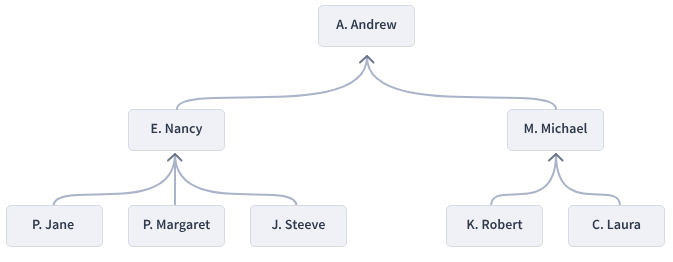

Efficient tree traversing requires the use of recursivity, especially in SQL. For this we use **recursive CTEs**. Recursive CTEs use **four ingredients**:

1. The `RECURSIVE` keyword announces the possible presence of a recursive query. We can use it even if there is no recursive query.

1. The **non-recursive or anchor member** represents a query to select the **tree root**. It's equivalent to the initialization step of a recursion.

1. The **compound-operator**, such as `UNION`, `UNION ALL`, `INTERSECT`, or `EXCEPT`, follows the anchor member.

1. The **recursive member** is the final part of the CTE, and it calls itself. It's equivalent to the recursive step of a recursion.

# 7) Recursive CTEs Anatomy

Look at the result of this query.

This table shows each employee with their level in the company hierarchy symbolized by `>`.

In [6]:
%%sql
WITH RECURSIVE
under_adams_table(employee_id, last_name, first_name, level) AS (
SELECT 1, 'Adams', 'Andrew', 0

 UNION ALL

SELECT e.employee_id, 
       e.last_name, 
       e.first_name, 
       u.level + 1 AS level
  FROM employee e
  JOIN under_adams_table u
    ON e.reports_to = u.employee_id
 ORDER BY level
)

SELECT SUBSTR('>>>', 1, level)  || ' '  || last_name  || ' ' || first_name AS hierarchy 
  FROM under_adams_table;

 * sqlite:///C:/sqlite/chinook2.db
Done.


hierarchy
Adams Andrew
> Edwards Nancy
> Mitchell Michael
>> Peacock Jane
>> Park Margaret
>> Johnson Steve
>> King Robert
>> Callahan Laura


Let's break down the different parts of the query:

1. We use WITH `RECURSIVE` to indicate that one or more of the CTEs can be recursive.

1. The **non-recursive** part represents the initialization, the root elements: `1`, `'Adams'`, `'Andrew'`, `0`. These values represent the `employee_id`, `last_name`, `first_name`, and `level`. 

    We indicated these names as the table's attributes: `under_adams_table(employee_id, last_name, first_name, level)`.

1. The compound operator is `UNION ALL`.

1. The recursive part calls `under_adams_table` (the name of the CTE); therefore, this is a recursive query.

In terms of execution:

1. SQL creates a table `under_adams_table`, which contains `1`, `'Adams'`, `'Andrew'`, `0`.

1. SQL searches all the rows of the `employee` table that have as manager the `employee_id` in `under_adams_table` table (at `initialization reports_to = 1`) and then increments the level.

1. SQL adds the result rows to the table `under_adams_table` because of the `UNION ALL` operator.

1. SQL returns to step 2 if there are still possible matches.

## Instructions

Complete the query available in the Code Editor to get the following table.

| path                                             |
|--------------------------------------------------|
| Adams Andrew                                     |
| Adams Andrew<--Edwards Nancy                     |
| Adams Andrew<--Mitchell Michael                  |
| Adams Andrew<--Edwards Nancy<--Peacock Jane      |
| Adams Andrew<--Edwards Nancy<--Park Margaret     |
| Adams Andrew<--Edwards Nancy<--Johnson Steve     |
| Adams Andrew<--Mitchell Michael<--King Robert    |
| Adams Andrew<--Mitchell Michael<--Callahan Laura |


Write the recursive member of the CTE.